In [161]:
import datasets
import roc_auc
from sklearn.neighbors import NearestNeighbors
from sklearn.base import BaseEstimator

In [43]:
class EstimatorKNN(BaseEstimator):
    def __init__(self, n_neighbors=3, algorithm='ball_tree'):
        self.param = {}
        self.param['n_neighbors'] = n_neighbors
        self.param['algorithm'] = algorithm
        self.estimator = NearestNeighbors(n_neighbors=n_neighbors, algorithm=algorithm)

    def fit(self, x):
        self.estimator.fit(x)
        return self 

    def predict(self, x):
        return [1.0]*len(x) 
    
    def decision_function(self, x, y=None):
        distances, indices = self.estimator.kneighbors(x)
        outlier_level = distances[:,-1]
        return outlier_level

    def score(self, x, y=None):
        scores = self.decision_function(x)
        return sum(scores)/len(scores)

    def get_params(self, deep=True):
        #return self.estimator.get_params(deep)
        return self.param

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self,parameter, value)
        return self
    
    def get_type(self):
        return 'kNN'

In [164]:
importlib.reload(roc_auc)

<module 'roc_auc' from 'roc_auc.ipynb'>

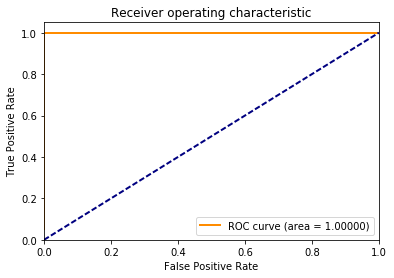

auc 1.00000


In [163]:
import importlib
#importlib.reload(roc_auc)
import roc_auc
import datasets

def eval01():
    sensor_type = ['rssi.a','rssi.b', ['linear_accel[0]','linear_accel[1]','linear_accel[2]']]
    n_record = 10
    drop_interval = 2
    ma_window = 2
    normalize = True
    
    # get data
    dfl_b = datasets.get_data(ds, title='01_01_01', before=n_record,
                              column=sensor_type, drop_interval=drop_interval)[:3]
    dfl_n = datasets.get_data(ds, title='01_01_02', before=n_record,
                              column=sensor_type, drop_interval=drop_interval)
    dfl_o = datasets.get_data(ds, title='01_02_02', before=n_record,
                              column=sensor_type, drop_interval=drop_interval)

    # moving average
    dfl_b = datasets.moving_average(dfl_b, window=ma_window, min_periods=ma_window)
    dfl_n = datasets.moving_average(dfl_n, window=ma_window, min_periods=ma_window)
    dfl_o = datasets.moving_average(dfl_o, window=ma_window, min_periods=ma_window)
    
    # normalize
    if normalize == True:
        dfl_b_n = datasets.normalize_by_base_data(dfl_b, dfl_b, sensor_type)
        dfl_n_n = datasets.normalize_by_base_data(dfl_b, dfl_n, sensor_type)
        dfl_o_n = datasets.normalize_by_base_data(dfl_b, dfl_o, sensor_type)

    # get numpy array
    data_2d_b = [df.as_matrix() for df in dfl_b_n]
    data_2d_n = [df.as_matrix() for df in dfl_n_n]
    data_2d_o = [df.as_matrix() for df in dfl_o_n]

    # to list of numpy.array
    data_b = [d.ravel() for d in data_2d_b]
    data_n = [d.ravel() for d in data_2d_n]
    data_o = [d.ravel() for d in data_2d_o]

    model = EstimatorKNN()
    model.fit(data_b)
    score_n = model.decision_function(data_n)
    score_o = model.decision_function(data_o)
    
    auc = roc_auc.get_auc_from_normal_outlier(score_n, score_o, graph=True)
#    auc = roc_auc.get_auc_from_normal_outlier(score_n, score_o, graph=False)

    print('auc %.05f' % (auc))
    
eval01()

In [1]:
# predict the next rssi value from current time value
import tensorflow as tf
import numpy as np
import random
import pandas as pd
import glob
import os
from tensorflow.contrib.tensorboard.plugins import projector
%matplotlib inline

In [2]:
#''' pred area judgement from rssi
num_of_sequence_length      = 10
num_of_hidden_nodes         = 20
num_of_training_epochs      = 100
size_of_mini_batch          = 10
size_of_test_batch          = 4
learning_rate               = 0.02

train_data = np.array([[-50., -50., -50., -51., -49., -47., -45., -44., -45., -49.],
                       [-53., -53., -53., -53., -51., -50., -50., -51., -52., -52.],
                       [-54., -54., -54., -53., -52., -50., -48., -48., -47., -46.],
                       [-49., -47., -46., -45., -44., -44., -42., -41., -41., -41.]])
test_data = np.array([[-63., -63., -64., -64., -63., -63., -63., -63., -63., -62.],
                      [-58., -59., -59., -59., -61., -61., -59., -56., -55., -54.],
                      [-65., -62., -62., -62., -61., -61., -60., -59., -60., -60.],
                      [-61., -61., -62., -62., -62., -61., -60., -61., -60., -60.]])
print(train_data)
print(test_data)
train_data *= -0.01
test_data *= -0.01

[[-50. -50. -50. -51. -49. -47. -45. -44. -45. -49.]
 [-53. -53. -53. -53. -51. -50. -50. -51. -52. -52.]
 [-54. -54. -54. -53. -52. -50. -48. -48. -47. -46.]
 [-49. -47. -46. -45. -44. -44. -42. -41. -41. -41.]]
[[-63. -63. -64. -64. -63. -63. -63. -63. -63. -62.]
 [-58. -59. -59. -59. -61. -61. -59. -56. -55. -54.]
 [-65. -62. -62. -62. -61. -61. -60. -59. -60. -60.]
 [-61. -61. -62. -62. -62. -61. -60. -61. -60. -60.]]


In [3]:
# fit
def fit(sess, _train_data):
    random.seed(0)
    np.random.seed(0)
    tf.set_random_seed(0)

    input_ph      = tf.placeholder(tf.float32, [None, num_of_sequence_length], name="input")
    supervisor_ph = tf.placeholder(tf.float32, [None, num_of_sequence_length], name="supervisor")
    batch_size_ph = tf.placeholder(tf.int32, name="batch_size")

    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

    with tf.name_scope("inference") as scope:
        weight_var = tf.Variable(tf.truncated_normal([num_of_sequence_length, num_of_hidden_nodes], stddev=0.1), name="weight")
        bias1_var   = tf.Variable(tf.truncated_normal([num_of_hidden_nodes], stddev=0.1), name="bias1")
        bias2_var   = tf.Variable(tf.truncated_normal([num_of_sequence_length], stddev=0.1), name="bias2")
        hidden = tf.sigmoid(tf.matmul(input_ph, weight_var) + bias1_var)
        output_op = tf.sigmoid(tf.matmul(hidden, tf.transpose(weight_var) + bias2_var))

    with tf.name_scope("loss") as scope:
        square_error = tf.reduce_mean(tf.square(output_op - supervisor_ph))
        loss_op      = square_error

    with tf.name_scope("training") as scope:
        training_op = optimizer.minimize(loss_op)

    init = tf.global_variables_initializer()

    saver = tf.train.Saver()
    sess.run(init)
    accuracy_results = []

    for epoch in range(num_of_training_epochs):
        train_dict = {
            input_ph: _train_data,
            supervisor_ph: _train_data,
            batch_size_ph: size_of_mini_batch,
        }
        sess.run(training_op, feed_dict=train_dict)

        if (epoch + 1) % 10 == 0:
            train_loss = sess.run(loss_op, feed_dict=train_dict)

            # eval accuracy
            pred_dict = {
                input_ph: _train_data,
                supervisor_ph: _train_data,
                batch_size_ph: size_of_test_batch,
            }
            accuracy_results.append([epoch, train_loss])
            preddata = sess.run(output_op, feed_dict=pred_dict)
            print("train#%d, train loss: %e" % (epoch + 1, train_loss))
            
    return (input_ph, supervisor_ph, batch_size_ph), loss_op, accuracy_results

In [4]:
# decision_function

def decision_function(sess, data, ph, loss):
    input_ph,  supervisor_ph, batch_size_ph = ph
    loss_op = loss
    
    _train_data = data
    
    for epoch in range(len(_train_data)):
        data = _train_data[epoch].reshape(-1, num_of_sequence_length)

        train_dict = {
            input_ph: data,
            supervisor_ph: data,
            batch_size_ph: 1,
        }

        train_loss = sess.run(loss_op, feed_dict=train_dict)
        print('test w/ train #.%d %f' % (epoch, train_loss))

sess = tf.Session()
ph, loss, accuracy_results = fit(sess, train_data)
decision_function(sess, train_data, ph, loss)
print('---')
decision_function(sess, test_data, ph, loss)

train#10, train loss: 4.780765e-03
train#20, train loss: 2.348111e-03
train#30, train loss: 1.490484e-03
train#40, train loss: 1.098775e-03
train#50, train loss: 1.011271e-03
train#60, train loss: 9.739301e-04
train#70, train loss: 9.545755e-04
train#80, train loss: 9.374364e-04
train#90, train loss: 9.205429e-04
train#100, train loss: 9.021317e-04
test w/ train #.0 0.000145
test w/ train #.1 0.001102
test w/ train #.2 0.000494
test w/ train #.3 0.001868
---
test w/ train #.0 0.018546
test w/ train #.1 0.008343
test w/ train #.2 0.013883
test w/ train #.3 0.013572


,epoch,train_loss
0,9,0.004781
1,19,0.002348
2,29,0.001490
3,39,0.001099
4,49,0.001011


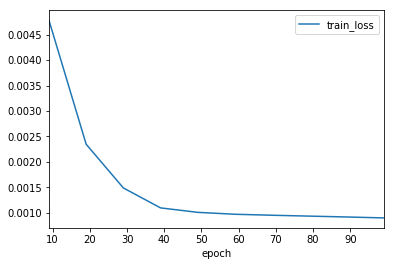

In [5]:
## result graph　
import matplotlib
import matplotlib.pyplot as plt

df = pd.DataFrame({
        'epoch': [x[0] for x in accuracy_results],
        'train_loss': [x[1] for x in accuracy_results]
    })
#        'epoch': range(10, 5010, 10)})
df.plot(x='epoch', y='train_loss')
df.head()